In [1]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType
import matplotlib.pyplot as plt


# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Model

In [2]:
# 분류 task
is_classification = True

### ResNet

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [4]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [5]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [6]:
from torch_frame import numerical, categorical, text_embedded, embedding

data_sizes = [5000, 10000, 30000, 50000, 70000]
resnet_results = []

for size in data_sizes:
    df = pd.read_csv("alzheimers_prediction_dataset.csv")

    # 데이터 사이즈별 추출 
    df = df.sample(n = size, random_state=42)

    ## 칼럼 별 Dtype 지정 
    col_to_stype={"Country" : categorical,
                "Age" : numerical,
                "Gender" : categorical,
                "Education Level" : numerical,
                "BMI" : numerical,
                "Physical Activity Level" : categorical,
                "Smoking Status" : categorical,
                "Alcohol Consumption" : categorical,
                "Diabetes" : categorical,
                "Hypertension" : categorical,
                "Cholesterol Level" : categorical,
                "Family History of Alzheimer’s" : categorical,
                "Cognitive Test Score" : numerical,
                "Depression Level" : categorical,
                "Sleep Quality" : categorical,
                "Dietary Habits" : categorical,
                "Air Pollution Exposure" : categorical,
                "Employment Status" : categorical,
                "Marital Status" : categorical,
                "Genetic Risk Factor (APOE-ε4 allele)" : categorical,
                "Social Engagement Level" : categorical,
                "Income Level" : categorical,
                "Stress Levels" : categorical,
                "Urban vs Rural Living" : categorical,
                "Alzheimer’s Diagnosis" : categorical
                }

    dataset = Dataset(df = df, 
                    col_to_stype = col_to_stype, 
                    target_col = "Alzheimer’s Diagnosis")

    dataset.materialize()
    
    # 여기에 데이터 셋을 나누고 모델을 학습하는 코드 추가
    train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]
    
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    test_tensor_frame = test_dataset.tensor_frame
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
    test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
        stype.categorical: EmbeddingEncoder(),
        stype.numerical: numerical_encoder,
    }
    
    if is_classification:
        #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
        output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
    else:
        output_channels = 1
    

    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels=output_channels,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)

    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels=output_channels,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')

    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

    
    # 훈련 및 테스트
    if is_classification:
        metric = 'Acc'
        best_val_metric = 0
        best_test_metric = 0
    else:
        metric = 'RMSE'
        best_val_metric = float('inf')
        best_test_metric = float('inf')

    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        test_metric = test(test_loader)

        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric

        print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
                f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

        print(f'Best Val {metric}: {best_val_metric:.4f}, '
                f'Best Test {metric}: {best_test_metric:.4f}')
        
    resnet_results.append(best_test_metric)
    


Epoch: 1: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


Train Loss: 0.7200, Train Acc: 0.5947, Val Acc: 0.5720, Test Acc: 0.5927
Best Val Acc: 0.5720, Best Test Acc: 0.5927


Epoch: 2: 100%|██████████| 12/12 [00:00<00:00, 99.77it/s]


Train Loss: 0.6534, Train Acc: 0.6370, Val Acc: 0.6120, Test Acc: 0.6453
Best Val Acc: 0.6120, Best Test Acc: 0.6453


Epoch: 3: 100%|██████████| 12/12 [00:00<00:00, 138.68it/s]


Train Loss: 0.6459, Train Acc: 0.6413, Val Acc: 0.6280, Test Acc: 0.6293
Best Val Acc: 0.6280, Best Test Acc: 0.6293


Epoch: 4: 100%|██████████| 12/12 [00:00<00:00, 135.74it/s]


Train Loss: 0.6411, Train Acc: 0.6490, Val Acc: 0.6300, Test Acc: 0.6380
Best Val Acc: 0.6300, Best Test Acc: 0.6380


Epoch: 5: 100%|██████████| 12/12 [00:00<00:00, 137.25it/s]


Train Loss: 0.6348, Train Acc: 0.6503, Val Acc: 0.6320, Test Acc: 0.6393
Best Val Acc: 0.6320, Best Test Acc: 0.6393


Epoch: 6: 100%|██████████| 12/12 [00:00<00:00, 143.21it/s]


Train Loss: 0.6259, Train Acc: 0.6657, Val Acc: 0.6540, Test Acc: 0.6487
Best Val Acc: 0.6540, Best Test Acc: 0.6487


Epoch: 7: 100%|██████████| 12/12 [00:00<00:00, 71.82it/s]


Train Loss: 0.6165, Train Acc: 0.6580, Val Acc: 0.6340, Test Acc: 0.6500
Best Val Acc: 0.6540, Best Test Acc: 0.6487


Epoch: 8: 100%|██████████| 12/12 [00:00<00:00, 84.26it/s]


Train Loss: 0.6069, Train Acc: 0.6950, Val Acc: 0.6400, Test Acc: 0.6467
Best Val Acc: 0.6540, Best Test Acc: 0.6487


Epoch: 9: 100%|██████████| 12/12 [00:00<00:00, 89.84it/s]


Train Loss: 0.5913, Train Acc: 0.7207, Val Acc: 0.6640, Test Acc: 0.6553
Best Val Acc: 0.6640, Best Test Acc: 0.6553


Epoch: 10: 100%|██████████| 12/12 [00:00<00:00, 89.64it/s]


Train Loss: 0.5728, Train Acc: 0.7387, Val Acc: 0.6560, Test Acc: 0.6780
Best Val Acc: 0.6640, Best Test Acc: 0.6553


Epoch: 11: 100%|██████████| 12/12 [00:00<00:00, 94.43it/s]


Train Loss: 0.5470, Train Acc: 0.7637, Val Acc: 0.6580, Test Acc: 0.6893
Best Val Acc: 0.6640, Best Test Acc: 0.6553


Epoch: 12: 100%|██████████| 12/12 [00:00<00:00, 134.83it/s]


Train Loss: 0.5311, Train Acc: 0.7677, Val Acc: 0.6760, Test Acc: 0.6807
Best Val Acc: 0.6760, Best Test Acc: 0.6807


Epoch: 13: 100%|██████████| 12/12 [00:00<00:00, 128.40it/s]


Train Loss: 0.5278, Train Acc: 0.7507, Val Acc: 0.6660, Test Acc: 0.6880
Best Val Acc: 0.6760, Best Test Acc: 0.6807


Epoch: 14: 100%|██████████| 12/12 [00:00<00:00, 154.25it/s]


Train Loss: 0.5073, Train Acc: 0.7953, Val Acc: 0.6760, Test Acc: 0.6940
Best Val Acc: 0.6760, Best Test Acc: 0.6807


Epoch: 15: 100%|██████████| 12/12 [00:00<00:00, 104.08it/s]


Train Loss: 0.4852, Train Acc: 0.7977, Val Acc: 0.6680, Test Acc: 0.6900
Best Val Acc: 0.6760, Best Test Acc: 0.6807


Epoch: 1: 100%|██████████| 24/24 [00:00<00:00, 142.33it/s]


Train Loss: 0.6713, Train Acc: 0.6322, Val Acc: 0.6480, Test Acc: 0.6327
Best Val Acc: 0.6480, Best Test Acc: 0.6327


Epoch: 2: 100%|██████████| 24/24 [00:00<00:00, 133.75it/s]


Train Loss: 0.6459, Train Acc: 0.6463, Val Acc: 0.6370, Test Acc: 0.6443
Best Val Acc: 0.6480, Best Test Acc: 0.6327


Epoch: 3: 100%|██████████| 24/24 [00:00<00:00, 133.94it/s]


Train Loss: 0.6339, Train Acc: 0.6608, Val Acc: 0.6540, Test Acc: 0.6497
Best Val Acc: 0.6540, Best Test Acc: 0.6497


Epoch: 4: 100%|██████████| 24/24 [00:00<00:00, 146.11it/s]


Train Loss: 0.6247, Train Acc: 0.6727, Val Acc: 0.6680, Test Acc: 0.6597
Best Val Acc: 0.6680, Best Test Acc: 0.6597


Epoch: 5: 100%|██████████| 24/24 [00:00<00:00, 149.48it/s]


Train Loss: 0.6040, Train Acc: 0.6952, Val Acc: 0.6720, Test Acc: 0.6777
Best Val Acc: 0.6720, Best Test Acc: 0.6777


Epoch: 6: 100%|██████████| 24/24 [00:00<00:00, 122.16it/s]


Train Loss: 0.5753, Train Acc: 0.7202, Val Acc: 0.7030, Test Acc: 0.6933
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 7: 100%|██████████| 24/24 [00:00<00:00, 131.72it/s]


Train Loss: 0.5559, Train Acc: 0.7358, Val Acc: 0.6960, Test Acc: 0.7130
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 8: 100%|██████████| 24/24 [00:00<00:00, 130.55it/s]


Train Loss: 0.5567, Train Acc: 0.7358, Val Acc: 0.6940, Test Acc: 0.7030
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 9: 100%|██████████| 24/24 [00:00<00:00, 135.48it/s]


Train Loss: 0.5383, Train Acc: 0.7465, Val Acc: 0.7000, Test Acc: 0.7137
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 10: 100%|██████████| 24/24 [00:00<00:00, 124.07it/s]


Train Loss: 0.5266, Train Acc: 0.7557, Val Acc: 0.7000, Test Acc: 0.7063
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 11: 100%|██████████| 24/24 [00:00<00:00, 108.95it/s]


Train Loss: 0.5149, Train Acc: 0.7622, Val Acc: 0.6920, Test Acc: 0.7147
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 12: 100%|██████████| 24/24 [00:00<00:00, 120.12it/s]


Train Loss: 0.5116, Train Acc: 0.7632, Val Acc: 0.6990, Test Acc: 0.7053
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 13: 100%|██████████| 24/24 [00:00<00:00, 137.12it/s]


Train Loss: 0.5060, Train Acc: 0.7702, Val Acc: 0.6970, Test Acc: 0.7043
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 14: 100%|██████████| 24/24 [00:00<00:00, 160.90it/s]


Train Loss: 0.5017, Train Acc: 0.7623, Val Acc: 0.6750, Test Acc: 0.6990
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 15: 100%|██████████| 24/24 [00:00<00:00, 134.30it/s]


Train Loss: 0.5002, Train Acc: 0.7887, Val Acc: 0.6960, Test Acc: 0.7037
Best Val Acc: 0.7030, Best Test Acc: 0.6933


Epoch: 1: 100%|██████████| 71/71 [00:00<00:00, 131.25it/s]


Train Loss: 0.6537, Train Acc: 0.6457, Val Acc: 0.6340, Test Acc: 0.6347
Best Val Acc: 0.6340, Best Test Acc: 0.6347


Epoch: 2: 100%|██████████| 71/71 [00:00<00:00, 129.71it/s]


Train Loss: 0.6210, Train Acc: 0.6787, Val Acc: 0.6713, Test Acc: 0.6627
Best Val Acc: 0.6713, Best Test Acc: 0.6627


Epoch: 3: 100%|██████████| 71/71 [00:00<00:00, 112.01it/s]


Train Loss: 0.5730, Train Acc: 0.6997, Val Acc: 0.7000, Test Acc: 0.6858
Best Val Acc: 0.7000, Best Test Acc: 0.6858


Epoch: 4: 100%|██████████| 71/71 [00:00<00:00, 120.55it/s]


Train Loss: 0.5504, Train Acc: 0.7192, Val Acc: 0.7110, Test Acc: 0.7026
Best Val Acc: 0.7110, Best Test Acc: 0.7026


Epoch: 5: 100%|██████████| 71/71 [00:00<00:00, 113.56it/s]


Train Loss: 0.5461, Train Acc: 0.7247, Val Acc: 0.7143, Test Acc: 0.7011
Best Val Acc: 0.7143, Best Test Acc: 0.7011


Epoch: 6: 100%|██████████| 71/71 [00:00<00:00, 115.19it/s]


Train Loss: 0.5410, Train Acc: 0.7227, Val Acc: 0.7170, Test Acc: 0.7013
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 7: 100%|██████████| 71/71 [00:00<00:00, 108.33it/s]


Train Loss: 0.5374, Train Acc: 0.7296, Val Acc: 0.7137, Test Acc: 0.7046
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 8: 100%|██████████| 71/71 [00:00<00:00, 87.73it/s] 


Train Loss: 0.5336, Train Acc: 0.7323, Val Acc: 0.7150, Test Acc: 0.6994
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 9: 100%|██████████| 71/71 [00:00<00:00, 119.88it/s]


Train Loss: 0.5331, Train Acc: 0.7377, Val Acc: 0.7107, Test Acc: 0.7003
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 10: 100%|██████████| 71/71 [00:00<00:00, 131.16it/s]


Train Loss: 0.5313, Train Acc: 0.7335, Val Acc: 0.7153, Test Acc: 0.7004
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 11: 100%|██████████| 71/71 [00:00<00:00, 130.02it/s]


Train Loss: 0.5265, Train Acc: 0.7400, Val Acc: 0.7157, Test Acc: 0.7040
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 12: 100%|██████████| 71/71 [00:00<00:00, 121.69it/s]


Train Loss: 0.5233, Train Acc: 0.7423, Val Acc: 0.7130, Test Acc: 0.7004
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 13: 100%|██████████| 71/71 [00:00<00:00, 115.56it/s]


Train Loss: 0.5175, Train Acc: 0.7463, Val Acc: 0.7037, Test Acc: 0.6989
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 14: 100%|██████████| 71/71 [00:00<00:00, 115.18it/s]


Train Loss: 0.5155, Train Acc: 0.7476, Val Acc: 0.7080, Test Acc: 0.6989
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 15: 100%|██████████| 71/71 [00:00<00:00, 119.88it/s]


Train Loss: 0.5123, Train Acc: 0.7538, Val Acc: 0.7067, Test Acc: 0.7021
Best Val Acc: 0.7170, Best Test Acc: 0.7013


Epoch: 1: 100%|██████████| 118/118 [00:00<00:00, 130.38it/s]


Train Loss: 0.6506, Train Acc: 0.6693, Val Acc: 0.6676, Test Acc: 0.6663
Best Val Acc: 0.6676, Best Test Acc: 0.6663


Epoch: 2: 100%|██████████| 118/118 [00:01<00:00, 101.03it/s]


Train Loss: 0.5784, Train Acc: 0.7082, Val Acc: 0.7140, Test Acc: 0.7059
Best Val Acc: 0.7140, Best Test Acc: 0.7059


Epoch: 3: 100%|██████████| 118/118 [00:01<00:00, 87.58it/s]


Train Loss: 0.5567, Train Acc: 0.7145, Val Acc: 0.7268, Test Acc: 0.7141
Best Val Acc: 0.7268, Best Test Acc: 0.7141


Epoch: 4: 100%|██████████| 118/118 [00:01<00:00, 114.89it/s]


Train Loss: 0.5492, Train Acc: 0.7017, Val Acc: 0.7082, Test Acc: 0.7041
Best Val Acc: 0.7268, Best Test Acc: 0.7141


Epoch: 5: 100%|██████████| 118/118 [00:00<00:00, 133.44it/s]


Train Loss: 0.5449, Train Acc: 0.7167, Val Acc: 0.7296, Test Acc: 0.7105
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 6: 100%|██████████| 118/118 [00:00<00:00, 119.68it/s]


Train Loss: 0.5438, Train Acc: 0.7193, Val Acc: 0.7230, Test Acc: 0.7126
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 7: 100%|██████████| 118/118 [00:01<00:00, 115.82it/s]


Train Loss: 0.5401, Train Acc: 0.7215, Val Acc: 0.7284, Test Acc: 0.7142
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 8: 100%|██████████| 118/118 [00:01<00:00, 105.74it/s]


Train Loss: 0.5395, Train Acc: 0.7235, Val Acc: 0.7246, Test Acc: 0.7113
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 9: 100%|██████████| 118/118 [00:00<00:00, 128.27it/s]


Train Loss: 0.5378, Train Acc: 0.7246, Val Acc: 0.7272, Test Acc: 0.7136
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 10: 100%|██████████| 118/118 [00:01<00:00, 112.28it/s]


Train Loss: 0.5352, Train Acc: 0.7257, Val Acc: 0.7260, Test Acc: 0.7113
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 11: 100%|██████████| 118/118 [00:01<00:00, 105.27it/s]


Train Loss: 0.5319, Train Acc: 0.7283, Val Acc: 0.7256, Test Acc: 0.7115
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 12: 100%|██████████| 118/118 [00:00<00:00, 125.04it/s]


Train Loss: 0.5294, Train Acc: 0.7340, Val Acc: 0.7258, Test Acc: 0.7105
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 13: 100%|██████████| 118/118 [00:01<00:00, 94.68it/s]


Train Loss: 0.5262, Train Acc: 0.7318, Val Acc: 0.7248, Test Acc: 0.7086
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 14: 100%|██████████| 118/118 [00:01<00:00, 75.38it/s]


Train Loss: 0.5240, Train Acc: 0.7380, Val Acc: 0.7238, Test Acc: 0.7063
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 15: 100%|██████████| 118/118 [00:01<00:00, 84.97it/s]


Train Loss: 0.5221, Train Acc: 0.7385, Val Acc: 0.7290, Test Acc: 0.7073
Best Val Acc: 0.7296, Best Test Acc: 0.7105


Epoch: 1: 100%|██████████| 165/165 [00:01<00:00, 114.10it/s]


Train Loss: 0.6362, Train Acc: 0.7017, Val Acc: 0.7036, Test Acc: 0.7022
Best Val Acc: 0.7036, Best Test Acc: 0.7022


Epoch: 2: 100%|██████████| 165/165 [00:01<00:00, 95.74it/s] 


Train Loss: 0.5596, Train Acc: 0.7141, Val Acc: 0.7196, Test Acc: 0.7136
Best Val Acc: 0.7196, Best Test Acc: 0.7136


Epoch: 3: 100%|██████████| 165/165 [00:01<00:00, 109.58it/s]


Train Loss: 0.5485, Train Acc: 0.7130, Val Acc: 0.7164, Test Acc: 0.7097
Best Val Acc: 0.7196, Best Test Acc: 0.7136


Epoch: 4: 100%|██████████| 165/165 [00:01<00:00, 114.33it/s]


Train Loss: 0.5447, Train Acc: 0.7186, Val Acc: 0.7197, Test Acc: 0.7163
Best Val Acc: 0.7197, Best Test Acc: 0.7163


Epoch: 5: 100%|██████████| 165/165 [00:01<00:00, 109.12it/s]


Train Loss: 0.5436, Train Acc: 0.7186, Val Acc: 0.7236, Test Acc: 0.7159
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 6: 100%|██████████| 165/165 [00:01<00:00, 94.06it/s]


Train Loss: 0.5410, Train Acc: 0.7200, Val Acc: 0.7213, Test Acc: 0.7131
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 7: 100%|██████████| 165/165 [00:01<00:00, 120.47it/s]


Train Loss: 0.5397, Train Acc: 0.7232, Val Acc: 0.7236, Test Acc: 0.7149
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 8: 100%|██████████| 165/165 [00:01<00:00, 108.64it/s]


Train Loss: 0.5360, Train Acc: 0.7179, Val Acc: 0.7126, Test Acc: 0.7116
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 9: 100%|██████████| 165/165 [00:01<00:00, 127.84it/s]


Train Loss: 0.5346, Train Acc: 0.7275, Val Acc: 0.7189, Test Acc: 0.7161
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 10: 100%|██████████| 165/165 [00:02<00:00, 78.46it/s]


Train Loss: 0.5315, Train Acc: 0.7295, Val Acc: 0.7201, Test Acc: 0.7187
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 11: 100%|██████████| 165/165 [00:01<00:00, 124.01it/s]


Train Loss: 0.5299, Train Acc: 0.7311, Val Acc: 0.7176, Test Acc: 0.7152
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 12: 100%|██████████| 165/165 [00:01<00:00, 125.05it/s]


Train Loss: 0.5278, Train Acc: 0.7257, Val Acc: 0.7121, Test Acc: 0.7070
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 13: 100%|██████████| 165/165 [00:01<00:00, 90.61it/s] 


Train Loss: 0.5253, Train Acc: 0.7329, Val Acc: 0.7180, Test Acc: 0.7137
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 14: 100%|██████████| 165/165 [00:01<00:00, 124.81it/s]


Train Loss: 0.5243, Train Acc: 0.7385, Val Acc: 0.7187, Test Acc: 0.7142
Best Val Acc: 0.7236, Best Test Acc: 0.7159


Epoch: 15: 100%|██████████| 165/165 [00:01<00:00, 103.62it/s]


Train Loss: 0.5221, Train Acc: 0.7320, Val Acc: 0.7134, Test Acc: 0.7098
Best Val Acc: 0.7236, Best Test Acc: 0.7159


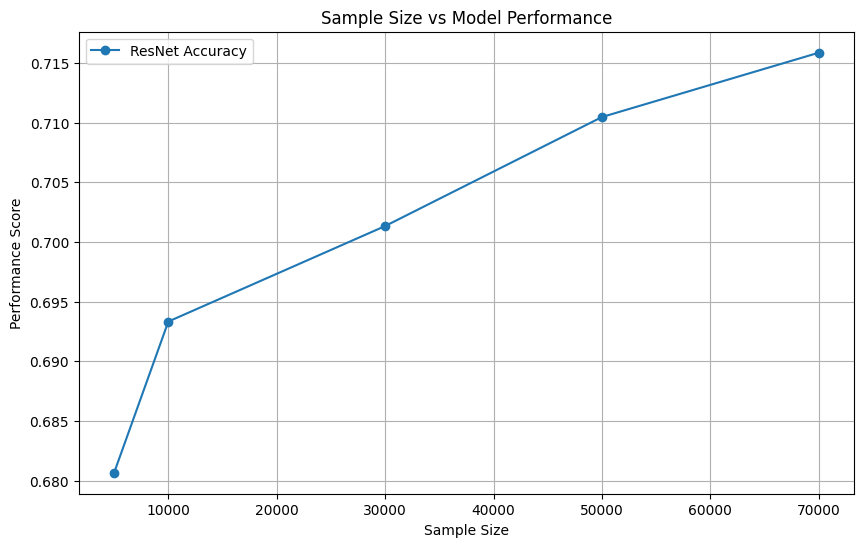

In [7]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, resnet_results, marker="o", linestyle="-", label="ResNet Accuracy")


#plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

### FT-T

In [8]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [9]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [10]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [12]:
from torch_frame import numerical, categorical, text_embedded, embedding

data_sizes = [5000, 10000, 30000, 50000, 70000]
ftt_results = []

for size in data_sizes:
    df = pd.read_csv("alzheimers_prediction_dataset.csv")

    # 데이터 사이즈별 추출 
    df = df.sample(n = size, random_state=42)

    ## 칼럼 별 Dtype 지정 
    col_to_stype={"Country" : categorical,
                "Age" : numerical,
                "Gender" : categorical,
                "Education Level" : numerical,
                "BMI" : numerical,
                "Physical Activity Level" : categorical,
                "Smoking Status" : categorical,
                "Alcohol Consumption" : categorical,
                "Diabetes" : categorical,
                "Hypertension" : categorical,
                "Cholesterol Level" : categorical,
                "Family History of Alzheimer’s" : categorical,
                "Cognitive Test Score" : numerical,
                "Depression Level" : categorical,
                "Sleep Quality" : categorical,
                "Dietary Habits" : categorical,
                "Air Pollution Exposure" : categorical,
                "Employment Status" : categorical,
                "Marital Status" : categorical,
                "Genetic Risk Factor (APOE-ε4 allele)" : categorical,
                "Social Engagement Level" : categorical,
                "Income Level" : categorical,
                "Stress Levels" : categorical,
                "Urban vs Rural Living" : categorical,
                "Alzheimer’s Diagnosis" : categorical
                }

    dataset = Dataset(df = df, 
                    col_to_stype = col_to_stype, 
                    target_col = "Alzheimer’s Diagnosis")

    dataset.materialize()
    
    # 여기에 데이터 셋을 나누고 모델을 학습하는 코드 추가
    train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]
    
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    test_tensor_frame = test_dataset.tensor_frame
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
    test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
        stype.categorical: EmbeddingEncoder(),
        stype.numerical: numerical_encoder,
    }
    
    if is_classification:
        #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
        output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
    else:
        output_channels = 1
    

    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels=output_channels,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)

    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels=output_channels,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')

    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

    
    # 훈련 및 테스트
    if is_classification:
        metric = 'Acc'
        best_val_metric = 0
        best_test_metric = 0
    else:
        metric = 'RMSE'
        best_val_metric = float('inf')
        best_test_metric = float('inf')

    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        test_metric = test(test_loader)

        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric

        print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
                f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

        print(f'Best Val {metric}: {best_val_metric:.4f}, '
                f'Best Test {metric}: {best_test_metric:.4f}')
        
    ftt_results.append(best_test_metric)
    

Epoch: 1: 100%|██████████| 12/12 [00:00<00:00, 55.41it/s]


Train Loss: 0.6914, Train Acc: 0.5990, Val Acc: 0.5820, Test Acc: 0.5987
Best Val Acc: 0.5820, Best Test Acc: 0.5987


Epoch: 2: 100%|██████████| 12/12 [00:00<00:00, 62.66it/s]


Train Loss: 0.6749, Train Acc: 0.6150, Val Acc: 0.5800, Test Acc: 0.6160
Best Val Acc: 0.5820, Best Test Acc: 0.5987


Epoch: 3: 100%|██████████| 12/12 [00:00<00:00, 35.15it/s]


Train Loss: 0.6634, Train Acc: 0.6287, Val Acc: 0.6080, Test Acc: 0.6340
Best Val Acc: 0.6080, Best Test Acc: 0.6340


Epoch: 4: 100%|██████████| 12/12 [00:00<00:00, 46.40it/s]


Train Loss: 0.6611, Train Acc: 0.6377, Val Acc: 0.6260, Test Acc: 0.6347
Best Val Acc: 0.6260, Best Test Acc: 0.6347


Epoch: 5: 100%|██████████| 12/12 [00:00<00:00, 53.14it/s]


Train Loss: 0.6585, Train Acc: 0.6457, Val Acc: 0.6300, Test Acc: 0.6300
Best Val Acc: 0.6300, Best Test Acc: 0.6300


Epoch: 6: 100%|██████████| 12/12 [00:00<00:00, 49.51it/s]


Train Loss: 0.6560, Train Acc: 0.6460, Val Acc: 0.6400, Test Acc: 0.6300
Best Val Acc: 0.6400, Best Test Acc: 0.6300


Epoch: 7: 100%|██████████| 12/12 [00:00<00:00, 34.98it/s]


Train Loss: 0.6459, Train Acc: 0.6433, Val Acc: 0.6280, Test Acc: 0.6360
Best Val Acc: 0.6400, Best Test Acc: 0.6300


Epoch: 8: 100%|██████████| 12/12 [00:00<00:00, 49.31it/s]


Train Loss: 0.6461, Train Acc: 0.6500, Val Acc: 0.6420, Test Acc: 0.6340
Best Val Acc: 0.6420, Best Test Acc: 0.6340


Epoch: 9: 100%|██████████| 12/12 [00:00<00:00, 60.90it/s]


Train Loss: 0.6438, Train Acc: 0.6577, Val Acc: 0.6420, Test Acc: 0.6333
Best Val Acc: 0.6420, Best Test Acc: 0.6340


Epoch: 10: 100%|██████████| 12/12 [00:00<00:00, 48.15it/s]


Train Loss: 0.6403, Train Acc: 0.6490, Val Acc: 0.6380, Test Acc: 0.6253
Best Val Acc: 0.6420, Best Test Acc: 0.6340


Epoch: 11: 100%|██████████| 12/12 [00:00<00:00, 58.33it/s]


Train Loss: 0.6358, Train Acc: 0.6630, Val Acc: 0.6380, Test Acc: 0.6420
Best Val Acc: 0.6420, Best Test Acc: 0.6340


Epoch: 12: 100%|██████████| 12/12 [00:00<00:00, 49.87it/s]


Train Loss: 0.6348, Train Acc: 0.6673, Val Acc: 0.6340, Test Acc: 0.6467
Best Val Acc: 0.6420, Best Test Acc: 0.6340


Epoch: 13: 100%|██████████| 12/12 [00:00<00:00, 57.85it/s]


Train Loss: 0.6336, Train Acc: 0.6597, Val Acc: 0.6380, Test Acc: 0.6307
Best Val Acc: 0.6420, Best Test Acc: 0.6340


Epoch: 14: 100%|██████████| 12/12 [00:00<00:00, 56.39it/s]


Train Loss: 0.6302, Train Acc: 0.6730, Val Acc: 0.6460, Test Acc: 0.6473
Best Val Acc: 0.6460, Best Test Acc: 0.6473


Epoch: 15: 100%|██████████| 12/12 [00:00<00:00, 43.29it/s]


Train Loss: 0.6235, Train Acc: 0.6763, Val Acc: 0.6440, Test Acc: 0.6407
Best Val Acc: 0.6460, Best Test Acc: 0.6473


Epoch: 1: 100%|██████████| 24/24 [00:00<00:00, 51.73it/s]


Train Loss: 0.6926, Train Acc: 0.6147, Val Acc: 0.6260, Test Acc: 0.6273
Best Val Acc: 0.6260, Best Test Acc: 0.6273


Epoch: 2: 100%|██████████| 24/24 [00:00<00:00, 43.69it/s]


Train Loss: 0.6699, Train Acc: 0.6250, Val Acc: 0.6280, Test Acc: 0.6163
Best Val Acc: 0.6280, Best Test Acc: 0.6163


Epoch: 3: 100%|██████████| 24/24 [00:00<00:00, 47.65it/s]


Train Loss: 0.6620, Train Acc: 0.6340, Val Acc: 0.6330, Test Acc: 0.6287
Best Val Acc: 0.6330, Best Test Acc: 0.6287


Epoch: 4: 100%|██████████| 24/24 [00:00<00:00, 48.36it/s]


Train Loss: 0.6600, Train Acc: 0.6408, Val Acc: 0.6420, Test Acc: 0.6387
Best Val Acc: 0.6420, Best Test Acc: 0.6387


Epoch: 5: 100%|██████████| 24/24 [00:00<00:00, 52.50it/s]


Train Loss: 0.6466, Train Acc: 0.6488, Val Acc: 0.6510, Test Acc: 0.6377
Best Val Acc: 0.6510, Best Test Acc: 0.6377


Epoch: 6: 100%|██████████| 24/24 [00:00<00:00, 52.92it/s]


Train Loss: 0.6429, Train Acc: 0.6435, Val Acc: 0.6350, Test Acc: 0.6357
Best Val Acc: 0.6510, Best Test Acc: 0.6377


Epoch: 7: 100%|██████████| 24/24 [00:00<00:00, 49.36it/s]


Train Loss: 0.6426, Train Acc: 0.6538, Val Acc: 0.6450, Test Acc: 0.6457
Best Val Acc: 0.6510, Best Test Acc: 0.6377


Epoch: 8: 100%|██████████| 24/24 [00:00<00:00, 50.94it/s]


Train Loss: 0.6335, Train Acc: 0.6622, Val Acc: 0.6680, Test Acc: 0.6530
Best Val Acc: 0.6680, Best Test Acc: 0.6530


Epoch: 9: 100%|██████████| 24/24 [00:00<00:00, 51.16it/s]


Train Loss: 0.6216, Train Acc: 0.6718, Val Acc: 0.6510, Test Acc: 0.6613
Best Val Acc: 0.6680, Best Test Acc: 0.6530


Epoch: 10: 100%|██████████| 24/24 [00:00<00:00, 49.83it/s]


Train Loss: 0.6100, Train Acc: 0.6818, Val Acc: 0.6800, Test Acc: 0.6813
Best Val Acc: 0.6800, Best Test Acc: 0.6813


Epoch: 11: 100%|██████████| 24/24 [00:00<00:00, 54.91it/s]


Train Loss: 0.5922, Train Acc: 0.7002, Val Acc: 0.6940, Test Acc: 0.6937
Best Val Acc: 0.6940, Best Test Acc: 0.6937


Epoch: 12: 100%|██████████| 24/24 [00:00<00:00, 60.47it/s]


Train Loss: 0.5661, Train Acc: 0.7247, Val Acc: 0.6980, Test Acc: 0.7113
Best Val Acc: 0.6980, Best Test Acc: 0.7113


Epoch: 13: 100%|██████████| 24/24 [00:00<00:00, 49.22it/s]


Train Loss: 0.5539, Train Acc: 0.7382, Val Acc: 0.6960, Test Acc: 0.7220
Best Val Acc: 0.6980, Best Test Acc: 0.7113


Epoch: 14: 100%|██████████| 24/24 [00:00<00:00, 45.33it/s]


Train Loss: 0.5533, Train Acc: 0.7220, Val Acc: 0.7040, Test Acc: 0.7163
Best Val Acc: 0.7040, Best Test Acc: 0.7163


Epoch: 15: 100%|██████████| 24/24 [00:00<00:00, 46.05it/s]


Train Loss: 0.5443, Train Acc: 0.7362, Val Acc: 0.7040, Test Acc: 0.7193
Best Val Acc: 0.7040, Best Test Acc: 0.7163


Epoch: 1: 100%|██████████| 71/71 [00:01<00:00, 54.23it/s]


Train Loss: 0.6714, Train Acc: 0.6325, Val Acc: 0.6137, Test Acc: 0.6184
Best Val Acc: 0.6137, Best Test Acc: 0.6184


Epoch: 2: 100%|██████████| 71/71 [00:01<00:00, 39.70it/s]


Train Loss: 0.6507, Train Acc: 0.6393, Val Acc: 0.6280, Test Acc: 0.6237
Best Val Acc: 0.6280, Best Test Acc: 0.6237


Epoch: 3: 100%|██████████| 71/71 [00:01<00:00, 35.53it/s]


Train Loss: 0.6390, Train Acc: 0.6634, Val Acc: 0.6510, Test Acc: 0.6450
Best Val Acc: 0.6510, Best Test Acc: 0.6450


Epoch: 4: 100%|██████████| 71/71 [00:01<00:00, 53.79it/s]


Train Loss: 0.5987, Train Acc: 0.7217, Val Acc: 0.7257, Test Acc: 0.7054
Best Val Acc: 0.7257, Best Test Acc: 0.7054


Epoch: 5: 100%|██████████| 71/71 [00:01<00:00, 54.91it/s]


Train Loss: 0.5537, Train Acc: 0.7222, Val Acc: 0.7230, Test Acc: 0.7074
Best Val Acc: 0.7257, Best Test Acc: 0.7054


Epoch: 6: 100%|██████████| 71/71 [00:01<00:00, 55.46it/s]


Train Loss: 0.5521, Train Acc: 0.7252, Val Acc: 0.7297, Test Acc: 0.7081
Best Val Acc: 0.7297, Best Test Acc: 0.7081


Epoch: 7: 100%|██████████| 71/71 [00:01<00:00, 42.17it/s]


Train Loss: 0.5430, Train Acc: 0.7281, Val Acc: 0.7287, Test Acc: 0.7098
Best Val Acc: 0.7297, Best Test Acc: 0.7081


Epoch: 8: 100%|██████████| 71/71 [00:01<00:00, 51.01it/s]


Train Loss: 0.5424, Train Acc: 0.7259, Val Acc: 0.7293, Test Acc: 0.7117
Best Val Acc: 0.7297, Best Test Acc: 0.7081


Epoch: 9: 100%|██████████| 71/71 [00:01<00:00, 44.23it/s]


Train Loss: 0.5389, Train Acc: 0.7282, Val Acc: 0.7250, Test Acc: 0.7108
Best Val Acc: 0.7297, Best Test Acc: 0.7081


Epoch: 10: 100%|██████████| 71/71 [00:01<00:00, 44.59it/s]


Train Loss: 0.5363, Train Acc: 0.7292, Val Acc: 0.7253, Test Acc: 0.7160
Best Val Acc: 0.7297, Best Test Acc: 0.7081


Epoch: 11: 100%|██████████| 71/71 [00:01<00:00, 55.13it/s]


Train Loss: 0.5372, Train Acc: 0.7283, Val Acc: 0.7323, Test Acc: 0.7127
Best Val Acc: 0.7323, Best Test Acc: 0.7127


Epoch: 12: 100%|██████████| 71/71 [00:01<00:00, 44.13it/s]


Train Loss: 0.5351, Train Acc: 0.7316, Val Acc: 0.7320, Test Acc: 0.7121
Best Val Acc: 0.7323, Best Test Acc: 0.7127


Epoch: 13: 100%|██████████| 71/71 [00:01<00:00, 50.67it/s]


Train Loss: 0.5330, Train Acc: 0.7302, Val Acc: 0.7273, Test Acc: 0.7142
Best Val Acc: 0.7323, Best Test Acc: 0.7127


Epoch: 14: 100%|██████████| 71/71 [00:01<00:00, 40.46it/s]


Train Loss: 0.5331, Train Acc: 0.7313, Val Acc: 0.7263, Test Acc: 0.7134
Best Val Acc: 0.7323, Best Test Acc: 0.7127


Epoch: 15: 100%|██████████| 71/71 [00:01<00:00, 52.11it/s]


Train Loss: 0.5322, Train Acc: 0.7269, Val Acc: 0.7200, Test Acc: 0.7099
Best Val Acc: 0.7323, Best Test Acc: 0.7127


Epoch: 1: 100%|██████████| 118/118 [00:02<00:00, 48.69it/s]


Train Loss: 0.6683, Train Acc: 0.6357, Val Acc: 0.6308, Test Acc: 0.6390
Best Val Acc: 0.6308, Best Test Acc: 0.6390


Epoch: 2: 100%|██████████| 118/118 [00:02<00:00, 50.89it/s]


Train Loss: 0.6423, Train Acc: 0.6588, Val Acc: 0.6634, Test Acc: 0.6605
Best Val Acc: 0.6634, Best Test Acc: 0.6605


Epoch: 3: 100%|██████████| 118/118 [00:02<00:00, 51.91it/s]


Train Loss: 0.5850, Train Acc: 0.7184, Val Acc: 0.7358, Test Acc: 0.7179
Best Val Acc: 0.7358, Best Test Acc: 0.7179


Epoch: 4: 100%|██████████| 118/118 [00:02<00:00, 53.67it/s]


Train Loss: 0.5538, Train Acc: 0.7170, Val Acc: 0.7208, Test Acc: 0.7121
Best Val Acc: 0.7358, Best Test Acc: 0.7179


Epoch: 5: 100%|██████████| 118/118 [00:02<00:00, 53.90it/s]


Train Loss: 0.5472, Train Acc: 0.7230, Val Acc: 0.7396, Test Acc: 0.7213
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 6: 100%|██████████| 118/118 [00:02<00:00, 47.07it/s]


Train Loss: 0.5435, Train Acc: 0.7228, Val Acc: 0.7370, Test Acc: 0.7219
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 7: 100%|██████████| 118/118 [00:02<00:00, 49.31it/s]


Train Loss: 0.5430, Train Acc: 0.7232, Val Acc: 0.7376, Test Acc: 0.7213
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 8: 100%|██████████| 118/118 [00:02<00:00, 46.06it/s]


Train Loss: 0.5391, Train Acc: 0.7259, Val Acc: 0.7372, Test Acc: 0.7220
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 9: 100%|██████████| 118/118 [00:02<00:00, 52.44it/s]


Train Loss: 0.5382, Train Acc: 0.7239, Val Acc: 0.7316, Test Acc: 0.7195
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 10: 100%|██████████| 118/118 [00:02<00:00, 57.51it/s]


Train Loss: 0.5358, Train Acc: 0.7262, Val Acc: 0.7354, Test Acc: 0.7217
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 11: 100%|██████████| 118/118 [00:02<00:00, 48.76it/s]


Train Loss: 0.5361, Train Acc: 0.7268, Val Acc: 0.7356, Test Acc: 0.7226
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 12: 100%|██████████| 118/118 [00:02<00:00, 45.66it/s]


Train Loss: 0.5350, Train Acc: 0.7246, Val Acc: 0.7294, Test Acc: 0.7180
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 13: 100%|██████████| 118/118 [00:02<00:00, 40.97it/s]


Train Loss: 0.5348, Train Acc: 0.7278, Val Acc: 0.7388, Test Acc: 0.7227
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 14: 100%|██████████| 118/118 [00:02<00:00, 52.19it/s]


Train Loss: 0.5325, Train Acc: 0.7273, Val Acc: 0.7374, Test Acc: 0.7203
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 15: 100%|██████████| 118/118 [00:02<00:00, 48.77it/s]


Train Loss: 0.5320, Train Acc: 0.7272, Val Acc: 0.7350, Test Acc: 0.7195
Best Val Acc: 0.7396, Best Test Acc: 0.7213


Epoch: 1: 100%|██████████| 165/165 [00:03<00:00, 49.56it/s]


Train Loss: 0.6642, Train Acc: 0.6441, Val Acc: 0.6483, Test Acc: 0.6419
Best Val Acc: 0.6483, Best Test Acc: 0.6419


Epoch: 2: 100%|██████████| 165/165 [00:03<00:00, 50.33it/s]


Train Loss: 0.6142, Train Acc: 0.7100, Val Acc: 0.7089, Test Acc: 0.7050
Best Val Acc: 0.7089, Best Test Acc: 0.7050


Epoch: 3: 100%|██████████| 165/165 [00:03<00:00, 45.07it/s]


Train Loss: 0.5542, Train Acc: 0.7232, Val Acc: 0.7260, Test Acc: 0.7204
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 4: 100%|██████████| 165/165 [00:03<00:00, 43.44it/s]


Train Loss: 0.5472, Train Acc: 0.7212, Val Acc: 0.7243, Test Acc: 0.7185
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 5: 100%|██████████| 165/165 [00:03<00:00, 52.13it/s]


Train Loss: 0.5441, Train Acc: 0.7216, Val Acc: 0.7214, Test Acc: 0.7194
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 6: 100%|██████████| 165/165 [00:03<00:00, 51.64it/s]


Train Loss: 0.5407, Train Acc: 0.7190, Val Acc: 0.7180, Test Acc: 0.7157
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 7: 100%|██████████| 165/165 [00:03<00:00, 42.06it/s]


Train Loss: 0.5406, Train Acc: 0.7245, Val Acc: 0.7241, Test Acc: 0.7213
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 8: 100%|██████████| 165/165 [00:02<00:00, 56.98it/s]


Train Loss: 0.5374, Train Acc: 0.7217, Val Acc: 0.7184, Test Acc: 0.7184
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 9: 100%|██████████| 165/165 [00:03<00:00, 54.76it/s]


Train Loss: 0.5371, Train Acc: 0.7228, Val Acc: 0.7194, Test Acc: 0.7180
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 10: 100%|██████████| 165/165 [00:02<00:00, 55.45it/s]


Train Loss: 0.5350, Train Acc: 0.7245, Val Acc: 0.7214, Test Acc: 0.7210
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 11: 100%|██████████| 165/165 [00:02<00:00, 58.34it/s]


Train Loss: 0.5334, Train Acc: 0.7251, Val Acc: 0.7239, Test Acc: 0.7205
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 12: 100%|██████████| 165/165 [00:02<00:00, 55.24it/s]


Train Loss: 0.5326, Train Acc: 0.7254, Val Acc: 0.7234, Test Acc: 0.7202
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 13: 100%|██████████| 165/165 [00:03<00:00, 53.60it/s]


Train Loss: 0.5322, Train Acc: 0.7277, Val Acc: 0.7246, Test Acc: 0.7224
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 14: 100%|██████████| 165/165 [00:02<00:00, 58.27it/s]


Train Loss: 0.5312, Train Acc: 0.7280, Val Acc: 0.7244, Test Acc: 0.7215
Best Val Acc: 0.7260, Best Test Acc: 0.7204


Epoch: 15: 100%|██████████| 165/165 [00:03<00:00, 53.36it/s]


Train Loss: 0.5305, Train Acc: 0.7268, Val Acc: 0.7223, Test Acc: 0.7200
Best Val Acc: 0.7260, Best Test Acc: 0.7204


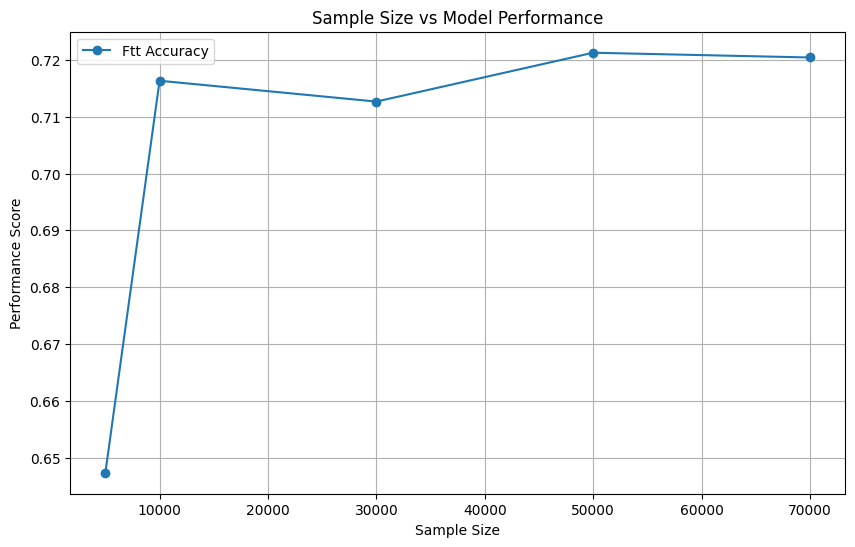

In [13]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, ftt_results, marker="o", linestyle="-", label="Ftt Accuracy")


#plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

### TabNet

In [14]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [15]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        loss = F.cross_entropy(pred, tf.y.long())
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        pred_class = pred.argmax(dim=-1)
        accum += float((tf.y == pred_class).sum())
        total_count += len(tf.y)

    return accum / total_count

In [16]:
from torch_frame import numerical, categorical, text_embedded, embedding

data_sizes = [5000, 10000, 30000, 50000, 70000]
tabnet_results = []

for size in data_sizes:
    df = pd.read_csv("alzheimers_prediction_dataset.csv")

    # 데이터 사이즈별 추출 
    df = df.sample(n = size, random_state=42)

    ## 칼럼 별 Dtype 지정 
    col_to_stype={"Country" : categorical,
                "Age" : numerical,
                "Gender" : categorical,
                "Education Level" : numerical,
                "BMI" : numerical,
                "Physical Activity Level" : categorical,
                "Smoking Status" : categorical,
                "Alcohol Consumption" : categorical,
                "Diabetes" : categorical,
                "Hypertension" : categorical,
                "Cholesterol Level" : categorical,
                "Family History of Alzheimer’s" : categorical,
                "Cognitive Test Score" : numerical,
                "Depression Level" : categorical,
                "Sleep Quality" : categorical,
                "Dietary Habits" : categorical,
                "Air Pollution Exposure" : categorical,
                "Employment Status" : categorical,
                "Marital Status" : categorical,
                "Genetic Risk Factor (APOE-ε4 allele)" : categorical,
                "Social Engagement Level" : categorical,
                "Income Level" : categorical,
                "Stress Levels" : categorical,
                "Urban vs Rural Living" : categorical,
                "Alzheimer’s Diagnosis" : categorical
                }

    dataset = Dataset(df = df, 
                    col_to_stype = col_to_stype, 
                    target_col = "Alzheimer’s Diagnosis")

    dataset.materialize()
    
    # 여기에 데이터 셋을 나누고 모델을 학습하는 코드 추가
    train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]
    
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    test_tensor_frame = test_dataset.tensor_frame
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                              shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
    test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

    # Set up model and optimizer
    model = TabNet(
        out_channels = 2,
        num_layers=args.num_layers,
        split_attn_channels=args.channels,
        split_feat_channels=args.channels,
        gamma=args.gamma,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

    
    # 훈련 및 테스트
    best_val_acc = 0
    best_test_acc = 0
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_acc = test(train_loader)
        val_acc = test(val_loader)
        test_acc = test(test_loader)
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
        lr_scheduler.step()

    print(f'Best Val Acc: {best_val_acc:.4f}, Best Test Acc: {best_test_acc:.4f}')
        
    tabnet_results.append(best_test_metric)
    

Epoch: 1: 100%|██████████| 12/12 [00:00<00:00, 69.62it/s]


Train Loss: 0.6920, Train Acc: 0.6057, Val Acc: 0.5980, Test Acc: 0.5967


Epoch: 2: 100%|██████████| 12/12 [00:00<00:00, 70.05it/s]


Train Loss: 0.6858, Train Acc: 0.6927, Val Acc: 0.6780, Test Acc: 0.6747


Epoch: 3: 100%|██████████| 12/12 [00:00<00:00, 72.67it/s]


Train Loss: 0.6742, Train Acc: 0.7067, Val Acc: 0.6620, Test Acc: 0.6860


Epoch: 4: 100%|██████████| 12/12 [00:00<00:00, 57.60it/s]


Train Loss: 0.6541, Train Acc: 0.7090, Val Acc: 0.6480, Test Acc: 0.6867


Epoch: 5: 100%|██████████| 12/12 [00:00<00:00, 70.70it/s]


Train Loss: 0.6258, Train Acc: 0.7047, Val Acc: 0.6640, Test Acc: 0.6833


Epoch: 6: 100%|██████████| 12/12 [00:00<00:00, 72.06it/s]


Train Loss: 0.5955, Train Acc: 0.7067, Val Acc: 0.6660, Test Acc: 0.6787


Epoch: 7: 100%|██████████| 12/12 [00:00<00:00, 70.60it/s]


Train Loss: 0.5625, Train Acc: 0.7077, Val Acc: 0.6700, Test Acc: 0.6787


Epoch: 8: 100%|██████████| 12/12 [00:00<00:00, 76.34it/s]


Train Loss: 0.5327, Train Acc: 0.7233, Val Acc: 0.6560, Test Acc: 0.6827


Epoch: 9: 100%|██████████| 12/12 [00:00<00:00, 52.87it/s]


Train Loss: 0.5041, Train Acc: 0.7440, Val Acc: 0.6720, Test Acc: 0.6820


Epoch: 10: 100%|██████████| 12/12 [00:00<00:00, 62.51it/s]


Train Loss: 0.4771, Train Acc: 0.7560, Val Acc: 0.6740, Test Acc: 0.6780


Epoch: 11: 100%|██████████| 12/12 [00:00<00:00, 74.46it/s]


Train Loss: 0.4531, Train Acc: 0.7687, Val Acc: 0.6680, Test Acc: 0.6733


Epoch: 12: 100%|██████████| 12/12 [00:00<00:00, 64.38it/s]


Train Loss: 0.4271, Train Acc: 0.7813, Val Acc: 0.6780, Test Acc: 0.6767


Epoch: 13: 100%|██████████| 12/12 [00:00<00:00, 69.26it/s]


Train Loss: 0.4102, Train Acc: 0.7917, Val Acc: 0.6740, Test Acc: 0.6787


Epoch: 14: 100%|██████████| 12/12 [00:00<00:00, 68.43it/s]


Train Loss: 0.3926, Train Acc: 0.7990, Val Acc: 0.6800, Test Acc: 0.6827


Epoch: 15: 100%|██████████| 12/12 [00:00<00:00, 51.30it/s]


Train Loss: 0.3763, Train Acc: 0.8053, Val Acc: 0.6760, Test Acc: 0.6767
Best Val Acc: 0.6800, Best Test Acc: 0.6827


Epoch: 1: 100%|██████████| 24/24 [00:00<00:00, 76.38it/s]


Train Loss: 0.6889, Train Acc: 0.6923, Val Acc: 0.6950, Test Acc: 0.6890


Epoch: 2: 100%|██████████| 24/24 [00:00<00:00, 67.64it/s]


Train Loss: 0.6634, Train Acc: 0.7037, Val Acc: 0.6980, Test Acc: 0.7087


Epoch: 3: 100%|██████████| 24/24 [00:00<00:00, 64.31it/s]


Train Loss: 0.6088, Train Acc: 0.7040, Val Acc: 0.6980, Test Acc: 0.7080


Epoch: 4: 100%|██████████| 24/24 [00:00<00:00, 65.96it/s]


Train Loss: 0.5720, Train Acc: 0.7058, Val Acc: 0.6950, Test Acc: 0.6950


Epoch: 5: 100%|██████████| 24/24 [00:00<00:00, 73.95it/s]


Train Loss: 0.5557, Train Acc: 0.7097, Val Acc: 0.6800, Test Acc: 0.6897


Epoch: 6: 100%|██████████| 24/24 [00:00<00:00, 59.78it/s]


Train Loss: 0.5374, Train Acc: 0.7240, Val Acc: 0.6870, Test Acc: 0.6980


Epoch: 7: 100%|██████████| 24/24 [00:00<00:00, 70.96it/s]


Train Loss: 0.5125, Train Acc: 0.7412, Val Acc: 0.6830, Test Acc: 0.7037


Epoch: 8: 100%|██████████| 24/24 [00:00<00:00, 72.30it/s]


Train Loss: 0.4913, Train Acc: 0.7512, Val Acc: 0.6790, Test Acc: 0.7007


Epoch: 9: 100%|██████████| 24/24 [00:00<00:00, 70.75it/s]


Train Loss: 0.4789, Train Acc: 0.7587, Val Acc: 0.6770, Test Acc: 0.7033


Epoch: 10: 100%|██████████| 24/24 [00:00<00:00, 70.65it/s]


Train Loss: 0.4597, Train Acc: 0.7670, Val Acc: 0.6740, Test Acc: 0.6960


Epoch: 11: 100%|██████████| 24/24 [00:00<00:00, 58.13it/s]


Train Loss: 0.4399, Train Acc: 0.7808, Val Acc: 0.6750, Test Acc: 0.6947


Epoch: 12: 100%|██████████| 24/24 [00:00<00:00, 57.65it/s]


Train Loss: 0.4280, Train Acc: 0.7890, Val Acc: 0.6810, Test Acc: 0.6963


Epoch: 13: 100%|██████████| 24/24 [00:00<00:00, 74.80it/s]


Train Loss: 0.4130, Train Acc: 0.7933, Val Acc: 0.6760, Test Acc: 0.6897


Epoch: 14: 100%|██████████| 24/24 [00:00<00:00, 64.83it/s]


Train Loss: 0.3931, Train Acc: 0.8043, Val Acc: 0.6750, Test Acc: 0.6863


Epoch: 15: 100%|██████████| 24/24 [00:00<00:00, 47.32it/s]


Train Loss: 0.3793, Train Acc: 0.8090, Val Acc: 0.6750, Test Acc: 0.6847
Best Val Acc: 0.6980, Best Test Acc: 0.7087


Epoch: 1: 100%|██████████| 71/71 [00:00<00:00, 78.41it/s]


Train Loss: 0.6721, Train Acc: 0.6991, Val Acc: 0.6940, Test Acc: 0.6828


Epoch: 2: 100%|██████████| 71/71 [00:01<00:00, 68.35it/s]


Train Loss: 0.5707, Train Acc: 0.7162, Val Acc: 0.7033, Test Acc: 0.6986


Epoch: 3: 100%|██████████| 71/71 [00:00<00:00, 74.27it/s]


Train Loss: 0.5431, Train Acc: 0.7242, Val Acc: 0.7030, Test Acc: 0.7018


Epoch: 4: 100%|██████████| 71/71 [00:01<00:00, 51.12it/s]


Train Loss: 0.5283, Train Acc: 0.7290, Val Acc: 0.7077, Test Acc: 0.7028


Epoch: 5: 100%|██████████| 71/71 [00:01<00:00, 70.68it/s]


Train Loss: 0.5185, Train Acc: 0.7344, Val Acc: 0.7087, Test Acc: 0.6997


Epoch: 6: 100%|██████████| 71/71 [00:00<00:00, 71.21it/s]


Train Loss: 0.5076, Train Acc: 0.7412, Val Acc: 0.7110, Test Acc: 0.6993


Epoch: 7: 100%|██████████| 71/71 [00:01<00:00, 69.71it/s]


Train Loss: 0.4998, Train Acc: 0.7484, Val Acc: 0.7060, Test Acc: 0.6953


Epoch: 8: 100%|██████████| 71/71 [00:01<00:00, 61.69it/s]


Train Loss: 0.4871, Train Acc: 0.7523, Val Acc: 0.7090, Test Acc: 0.6949


Epoch: 9: 100%|██████████| 71/71 [00:01<00:00, 59.75it/s]


Train Loss: 0.4796, Train Acc: 0.7596, Val Acc: 0.7053, Test Acc: 0.6928


Epoch: 10: 100%|██████████| 71/71 [00:01<00:00, 68.91it/s]


Train Loss: 0.4683, Train Acc: 0.7645, Val Acc: 0.7060, Test Acc: 0.6903


Epoch: 11: 100%|██████████| 71/71 [00:00<00:00, 72.79it/s]


Train Loss: 0.4582, Train Acc: 0.7699, Val Acc: 0.7023, Test Acc: 0.6861


Epoch: 12: 100%|██████████| 71/71 [00:01<00:00, 68.60it/s]


Train Loss: 0.4485, Train Acc: 0.7750, Val Acc: 0.7057, Test Acc: 0.6830


Epoch: 13: 100%|██████████| 71/71 [00:01<00:00, 64.64it/s]


Train Loss: 0.4423, Train Acc: 0.7800, Val Acc: 0.6997, Test Acc: 0.6817


Epoch: 14: 100%|██████████| 71/71 [00:01<00:00, 70.72it/s]


Train Loss: 0.4317, Train Acc: 0.7862, Val Acc: 0.6977, Test Acc: 0.6791


Epoch: 15: 100%|██████████| 71/71 [00:00<00:00, 71.97it/s]


Train Loss: 0.4216, Train Acc: 0.7918, Val Acc: 0.6970, Test Acc: 0.6808
Best Val Acc: 0.7110, Best Test Acc: 0.6993


Epoch: 1: 100%|██████████| 118/118 [00:01<00:00, 60.53it/s]


Train Loss: 0.6377, Train Acc: 0.7028, Val Acc: 0.7076, Test Acc: 0.7026


Epoch: 2: 100%|██████████| 118/118 [00:01<00:00, 69.23it/s]


Train Loss: 0.5600, Train Acc: 0.7133, Val Acc: 0.7220, Test Acc: 0.7129


Epoch: 3: 100%|██████████| 118/118 [00:01<00:00, 60.90it/s]


Train Loss: 0.5452, Train Acc: 0.7194, Val Acc: 0.7238, Test Acc: 0.7154


Epoch: 4: 100%|██████████| 118/118 [00:01<00:00, 66.57it/s]


Train Loss: 0.5383, Train Acc: 0.7221, Val Acc: 0.7224, Test Acc: 0.7169


Epoch: 5: 100%|██████████| 118/118 [00:02<00:00, 58.53it/s]


Train Loss: 0.5320, Train Acc: 0.7257, Val Acc: 0.7194, Test Acc: 0.7133


Epoch: 6: 100%|██████████| 118/118 [00:01<00:00, 63.60it/s]


Train Loss: 0.5251, Train Acc: 0.7291, Val Acc: 0.7206, Test Acc: 0.7097


Epoch: 7: 100%|██████████| 118/118 [00:01<00:00, 68.79it/s]


Train Loss: 0.5193, Train Acc: 0.7317, Val Acc: 0.7146, Test Acc: 0.7111


Epoch: 8: 100%|██████████| 118/118 [00:01<00:00, 67.69it/s]


Train Loss: 0.5147, Train Acc: 0.7361, Val Acc: 0.7164, Test Acc: 0.7097


Epoch: 9: 100%|██████████| 118/118 [00:01<00:00, 59.48it/s]


Train Loss: 0.5076, Train Acc: 0.7406, Val Acc: 0.7158, Test Acc: 0.7100


Epoch: 10: 100%|██████████| 118/118 [00:01<00:00, 70.85it/s]


Train Loss: 0.4990, Train Acc: 0.7467, Val Acc: 0.7166, Test Acc: 0.7071


Epoch: 11: 100%|██████████| 118/118 [00:02<00:00, 53.29it/s]


Train Loss: 0.4945, Train Acc: 0.7459, Val Acc: 0.7138, Test Acc: 0.7094


Epoch: 12: 100%|██████████| 118/118 [00:01<00:00, 67.96it/s]


Train Loss: 0.4865, Train Acc: 0.7543, Val Acc: 0.7144, Test Acc: 0.7038


Epoch: 13: 100%|██████████| 118/118 [00:01<00:00, 62.20it/s]


Train Loss: 0.4788, Train Acc: 0.7563, Val Acc: 0.7180, Test Acc: 0.7071


Epoch: 14: 100%|██████████| 118/118 [00:01<00:00, 59.98it/s]


Train Loss: 0.4728, Train Acc: 0.7636, Val Acc: 0.7130, Test Acc: 0.7019


Epoch: 15: 100%|██████████| 118/118 [00:01<00:00, 67.43it/s]


Train Loss: 0.4672, Train Acc: 0.7660, Val Acc: 0.7120, Test Acc: 0.7013
Best Val Acc: 0.7238, Best Test Acc: 0.7154


Epoch: 1: 100%|██████████| 165/165 [00:02<00:00, 76.41it/s]


Train Loss: 0.6157, Train Acc: 0.7093, Val Acc: 0.7093, Test Acc: 0.7027


Epoch: 2: 100%|██████████| 165/165 [00:02<00:00, 60.93it/s]


Train Loss: 0.5517, Train Acc: 0.7200, Val Acc: 0.7159, Test Acc: 0.7147


Epoch: 3: 100%|██████████| 165/165 [00:02<00:00, 63.85it/s]


Train Loss: 0.5405, Train Acc: 0.7216, Val Acc: 0.7171, Test Acc: 0.7138


Epoch: 4: 100%|██████████| 165/165 [00:02<00:00, 56.45it/s]


Train Loss: 0.5361, Train Acc: 0.7233, Val Acc: 0.7193, Test Acc: 0.7151


Epoch: 5: 100%|██████████| 165/165 [00:03<00:00, 51.25it/s]


Train Loss: 0.5325, Train Acc: 0.7250, Val Acc: 0.7191, Test Acc: 0.7126


Epoch: 6: 100%|██████████| 165/165 [00:02<00:00, 67.13it/s]


Train Loss: 0.5275, Train Acc: 0.7287, Val Acc: 0.7150, Test Acc: 0.7116


Epoch: 7: 100%|██████████| 165/165 [00:02<00:00, 72.47it/s]


Train Loss: 0.5240, Train Acc: 0.7323, Val Acc: 0.7184, Test Acc: 0.7116


Epoch: 8: 100%|██████████| 165/165 [00:02<00:00, 66.34it/s]


Train Loss: 0.5180, Train Acc: 0.7354, Val Acc: 0.7160, Test Acc: 0.7080


Epoch: 9: 100%|██████████| 165/165 [00:02<00:00, 67.67it/s]


Train Loss: 0.5135, Train Acc: 0.7376, Val Acc: 0.7111, Test Acc: 0.7045


Epoch: 10: 100%|██████████| 165/165 [00:02<00:00, 62.65it/s]


Train Loss: 0.5066, Train Acc: 0.7428, Val Acc: 0.7119, Test Acc: 0.7041


Epoch: 11: 100%|██████████| 165/165 [00:02<00:00, 77.32it/s]


Train Loss: 0.5032, Train Acc: 0.7450, Val Acc: 0.7139, Test Acc: 0.7055


Epoch: 12: 100%|██████████| 165/165 [00:02<00:00, 70.00it/s]


Train Loss: 0.4975, Train Acc: 0.7477, Val Acc: 0.7119, Test Acc: 0.6995


Epoch: 13: 100%|██████████| 165/165 [00:02<00:00, 65.69it/s]


Train Loss: 0.4910, Train Acc: 0.7522, Val Acc: 0.7090, Test Acc: 0.6974


Epoch: 14: 100%|██████████| 165/165 [00:02<00:00, 69.11it/s]


Train Loss: 0.4860, Train Acc: 0.7570, Val Acc: 0.7097, Test Acc: 0.6990


Epoch: 15: 100%|██████████| 165/165 [00:02<00:00, 71.86it/s]


Train Loss: 0.4792, Train Acc: 0.7592, Val Acc: 0.7059, Test Acc: 0.6965
Best Val Acc: 0.7193, Best Test Acc: 0.7151


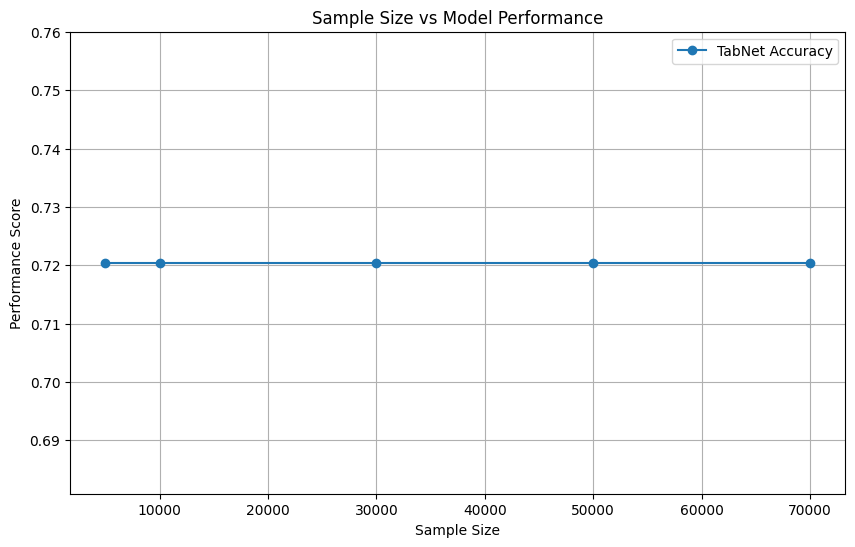

In [17]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, tabnet_results, marker="o", linestyle="-", label="TabNet Accuracy")


#plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

### Tab_Transformer

In [18]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [19]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.cross_entropy(pred, tf.y.long())   # expected scalar type Long but found Float 때문에 tf.y => tf.y.long()
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [20]:
from torch_frame import numerical, categorical, text_embedded, embedding

data_sizes = [5000, 10000, 30000, 50000, 70000]
Tab_Transformer_results = []

for size in data_sizes:
    df = pd.read_csv("alzheimers_prediction_dataset.csv")

    # 데이터 사이즈별 추출 
    df = df.sample(n = size, random_state=42)

    ## 칼럼 별 Dtype 지정 
    col_to_stype={"Country" : categorical,
                "Age" : numerical,
                "Gender" : categorical,
                "Education Level" : numerical,
                "BMI" : numerical,
                "Physical Activity Level" : categorical,
                "Smoking Status" : categorical,
                "Alcohol Consumption" : categorical,
                "Diabetes" : categorical,
                "Hypertension" : categorical,
                "Cholesterol Level" : categorical,
                "Family History of Alzheimer’s" : categorical,
                "Cognitive Test Score" : numerical,
                "Depression Level" : categorical,
                "Sleep Quality" : categorical,
                "Dietary Habits" : categorical,
                "Air Pollution Exposure" : categorical,
                "Employment Status" : categorical,
                "Marital Status" : categorical,
                "Genetic Risk Factor (APOE-ε4 allele)" : categorical,
                "Social Engagement Level" : categorical,
                "Income Level" : categorical,
                "Stress Levels" : categorical,
                "Urban vs Rural Living" : categorical,
                "Alzheimer’s Diagnosis" : categorical
                }

    dataset = Dataset(df = df, 
                    col_to_stype = col_to_stype, 
                    target_col = "Alzheimer’s Diagnosis")

    dataset.materialize()
    
    # 여기에 데이터 셋을 나누고 모델을 학습하는 코드 추가
    train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]
    
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    test_tensor_frame = test_dataset.tensor_frame
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
    test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)    

    # Set up model and optimizer
    model = TabTransformer(
        channels=args.channels,
        out_channels= 2,        # stype 문제로 수동으로 설정 
        num_layers=args.num_layers,
        num_heads=args.num_heads,
        encoder_pad_size=args.encoder_pad_size,
        attn_dropout=args.attention_dropout,
        ffn_dropout=args.ffn_dropout,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

    
    # 훈련 및 테스트
    metric = 'ACC'
    best_val_metric = 0
    best_test_metric = 0
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        test_metric = test(test_loader)

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric

        print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')
        lr_scheduler.step()

    print(f'Best Val {metric}: {best_val_metric:.4f}, '
          f'Best Test {metric}: {best_test_metric:.4f}')
        
    Tab_Transformer_results.append(best_test_metric)
    

Epoch: 1: 100%|██████████| 12/12 [00:01<00:00, 11.09it/s]


Train Loss: 2.8653, Train ACC: 0.6543, Val ACC: 0.6800, Test ACC: 0.6540


Epoch: 2: 100%|██████████| 12/12 [00:00<00:00, 14.97it/s]


Train Loss: 2.7808, Train ACC: 0.6310, Val ACC: 0.6140, Test ACC: 0.6260


Epoch: 3: 100%|██████████| 12/12 [00:00<00:00, 15.12it/s]


Train Loss: 1.7009, Train ACC: 0.6497, Val ACC: 0.6560, Test ACC: 0.6360


Epoch: 4: 100%|██████████| 12/12 [00:00<00:00, 14.97it/s]


Train Loss: 1.2286, Train ACC: 0.6357, Val ACC: 0.6860, Test ACC: 0.6447


Epoch: 5: 100%|██████████| 12/12 [00:00<00:00, 14.30it/s]


Train Loss: 1.0758, Train ACC: 0.6527, Val ACC: 0.6400, Test ACC: 0.6527


Epoch: 6: 100%|██████████| 12/12 [00:00<00:00, 15.06it/s]


Train Loss: 0.8164, Train ACC: 0.6753, Val ACC: 0.6740, Test ACC: 0.6640


Epoch: 7: 100%|██████████| 12/12 [00:00<00:00, 14.97it/s]


Train Loss: 0.7388, Train ACC: 0.6693, Val ACC: 0.6760, Test ACC: 0.6613


Epoch: 8: 100%|██████████| 12/12 [00:00<00:00, 15.09it/s]


Train Loss: 0.6861, Train ACC: 0.6623, Val ACC: 0.6920, Test ACC: 0.6573


Epoch: 9: 100%|██████████| 12/12 [00:00<00:00, 15.06it/s]


Train Loss: 0.6762, Train ACC: 0.6667, Val ACC: 0.6800, Test ACC: 0.6540


Epoch: 10: 100%|██████████| 12/12 [00:00<00:00, 14.96it/s]


Train Loss: 0.6411, Train ACC: 0.6600, Val ACC: 0.6720, Test ACC: 0.6513


Epoch: 11: 100%|██████████| 12/12 [00:00<00:00, 14.97it/s]


Train Loss: 0.6384, Train ACC: 0.6713, Val ACC: 0.6740, Test ACC: 0.6680


Epoch: 12: 100%|██████████| 12/12 [00:00<00:00, 12.67it/s]


Train Loss: 0.6359, Train ACC: 0.6740, Val ACC: 0.6920, Test ACC: 0.6613


Epoch: 13: 100%|██████████| 12/12 [00:00<00:00, 14.99it/s]


Train Loss: 0.6257, Train ACC: 0.6817, Val ACC: 0.6880, Test ACC: 0.6787


Epoch: 14: 100%|██████████| 12/12 [00:00<00:00, 13.27it/s]


Train Loss: 0.6241, Train ACC: 0.6810, Val ACC: 0.6920, Test ACC: 0.6773


Epoch: 15: 100%|██████████| 12/12 [00:00<00:00, 15.02it/s]


Train Loss: 0.6149, Train ACC: 0.6657, Val ACC: 0.6780, Test ACC: 0.6600
Best Val ACC: 0.6920, Best Test ACC: 0.6573


Epoch: 1: 100%|██████████| 24/24 [00:01<00:00, 14.61it/s]


Train Loss: 2.7933, Train ACC: 0.5590, Val ACC: 0.5460, Test ACC: 0.5530


Epoch: 2: 100%|██████████| 24/24 [00:01<00:00, 14.34it/s]


Train Loss: 1.5045, Train ACC: 0.6417, Val ACC: 0.6450, Test ACC: 0.6420


Epoch: 3: 100%|██████████| 24/24 [00:01<00:00, 13.94it/s]


Train Loss: 0.9181, Train ACC: 0.6490, Val ACC: 0.6530, Test ACC: 0.6497


Epoch: 4: 100%|██████████| 24/24 [00:01<00:00, 14.81it/s]


Train Loss: 0.7109, Train ACC: 0.6662, Val ACC: 0.6660, Test ACC: 0.6847


Epoch: 5: 100%|██████████| 24/24 [00:01<00:00, 14.76it/s]


Train Loss: 0.6563, Train ACC: 0.6555, Val ACC: 0.6680, Test ACC: 0.6590


Epoch: 6: 100%|██████████| 24/24 [00:01<00:00, 14.83it/s]


Train Loss: 0.6382, Train ACC: 0.6743, Val ACC: 0.6880, Test ACC: 0.6727


Epoch: 7: 100%|██████████| 24/24 [00:01<00:00, 14.12it/s]


Train Loss: 0.6287, Train ACC: 0.6857, Val ACC: 0.6730, Test ACC: 0.6793


Epoch: 8: 100%|██████████| 24/24 [00:01<00:00, 14.77it/s]


Train Loss: 0.6222, Train ACC: 0.6688, Val ACC: 0.6930, Test ACC: 0.6757


Epoch: 9: 100%|██████████| 24/24 [00:01<00:00, 14.81it/s]


Train Loss: 0.6200, Train ACC: 0.6697, Val ACC: 0.6700, Test ACC: 0.6777


Epoch: 10: 100%|██████████| 24/24 [00:01<00:00, 14.74it/s]


Train Loss: 0.6092, Train ACC: 0.6803, Val ACC: 0.6750, Test ACC: 0.6773


Epoch: 11: 100%|██████████| 24/24 [00:01<00:00, 14.75it/s]


Train Loss: 0.6175, Train ACC: 0.6673, Val ACC: 0.6620, Test ACC: 0.6740


Epoch: 12: 100%|██████████| 24/24 [00:01<00:00, 14.82it/s]


Train Loss: 0.6109, Train ACC: 0.6722, Val ACC: 0.6630, Test ACC: 0.6763


Epoch: 13: 100%|██████████| 24/24 [00:01<00:00, 14.77it/s]


Train Loss: 0.6112, Train ACC: 0.6752, Val ACC: 0.6730, Test ACC: 0.6857


Epoch: 14: 100%|██████████| 24/24 [00:01<00:00, 14.46it/s]


Train Loss: 0.6149, Train ACC: 0.6763, Val ACC: 0.6830, Test ACC: 0.6760


Epoch: 15: 100%|██████████| 24/24 [00:01<00:00, 14.75it/s]


Train Loss: 0.6077, Train ACC: 0.6758, Val ACC: 0.6850, Test ACC: 0.6757
Best Val ACC: 0.6930, Best Test ACC: 0.6757


Epoch: 1: 100%|██████████| 71/71 [00:04<00:00, 14.37it/s]


Train Loss: 1.6938, Train ACC: 0.6693, Val ACC: 0.6747, Test ACC: 0.6592


Epoch: 2: 100%|██████████| 71/71 [00:04<00:00, 14.43it/s]


Train Loss: 0.6611, Train ACC: 0.6599, Val ACC: 0.6607, Test ACC: 0.6493


Epoch: 3: 100%|██████████| 71/71 [00:04<00:00, 14.36it/s]


Train Loss: 0.6280, Train ACC: 0.6716, Val ACC: 0.6737, Test ACC: 0.6533


Epoch: 4: 100%|██████████| 71/71 [00:05<00:00, 14.11it/s]


Train Loss: 0.6224, Train ACC: 0.6734, Val ACC: 0.6683, Test ACC: 0.6571


Epoch: 5: 100%|██████████| 71/71 [00:04<00:00, 14.26it/s]


Train Loss: 0.6203, Train ACC: 0.6682, Val ACC: 0.6567, Test ACC: 0.6523


Epoch: 6: 100%|██████████| 71/71 [00:04<00:00, 14.29it/s]


Train Loss: 0.6168, Train ACC: 0.6658, Val ACC: 0.6633, Test ACC: 0.6494


Epoch: 7: 100%|██████████| 71/71 [00:04<00:00, 14.38it/s]


Train Loss: 0.6166, Train ACC: 0.6356, Val ACC: 0.6230, Test ACC: 0.6222


Epoch: 8: 100%|██████████| 71/71 [00:04<00:00, 14.48it/s]


Train Loss: 0.6207, Train ACC: 0.6684, Val ACC: 0.6563, Test ACC: 0.6552


Epoch: 9: 100%|██████████| 71/71 [00:04<00:00, 14.47it/s]


Train Loss: 0.6097, Train ACC: 0.6598, Val ACC: 0.6470, Test ACC: 0.6491


Epoch: 10: 100%|██████████| 71/71 [00:04<00:00, 14.36it/s]


Train Loss: 0.6083, Train ACC: 0.6736, Val ACC: 0.6717, Test ACC: 0.6567


Epoch: 11: 100%|██████████| 71/71 [00:04<00:00, 14.23it/s]


Train Loss: 0.6069, Train ACC: 0.6567, Val ACC: 0.6563, Test ACC: 0.6416


Epoch: 12: 100%|██████████| 71/71 [00:05<00:00, 13.90it/s]


Train Loss: 0.6061, Train ACC: 0.6727, Val ACC: 0.6667, Test ACC: 0.6602


Epoch: 13: 100%|██████████| 71/71 [00:05<00:00, 14.03it/s]


Train Loss: 0.6027, Train ACC: 0.6667, Val ACC: 0.6600, Test ACC: 0.6504


Epoch: 14: 100%|██████████| 71/71 [00:04<00:00, 14.43it/s]


Train Loss: 0.6017, Train ACC: 0.6725, Val ACC: 0.6637, Test ACC: 0.6523


Epoch: 15: 100%|██████████| 71/71 [00:04<00:00, 14.41it/s]


Train Loss: 0.6013, Train ACC: 0.6780, Val ACC: 0.6727, Test ACC: 0.6628
Best Val ACC: 0.6747, Best Test ACC: 0.6592


Epoch: 1: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Train Loss: 1.2968, Train ACC: 0.6630, Val ACC: 0.6702, Test ACC: 0.6677


Epoch: 2: 100%|██████████| 118/118 [00:08<00:00, 14.30it/s]


Train Loss: 0.6340, Train ACC: 0.6567, Val ACC: 0.6608, Test ACC: 0.6655


Epoch: 3: 100%|██████████| 118/118 [00:08<00:00, 14.33it/s]


Train Loss: 0.6278, Train ACC: 0.6432, Val ACC: 0.6482, Test ACC: 0.6514


Epoch: 4: 100%|██████████| 118/118 [00:08<00:00, 14.40it/s]


Train Loss: 0.6217, Train ACC: 0.6597, Val ACC: 0.6672, Test ACC: 0.6644


Epoch: 5: 100%|██████████| 118/118 [00:08<00:00, 14.45it/s]


Train Loss: 0.6147, Train ACC: 0.6620, Val ACC: 0.6620, Test ACC: 0.6631


Epoch: 6: 100%|██████████| 118/118 [00:08<00:00, 14.38it/s]


Train Loss: 0.6197, Train ACC: 0.6538, Val ACC: 0.6606, Test ACC: 0.6581


Epoch: 7: 100%|██████████| 118/118 [00:08<00:00, 14.21it/s]


Train Loss: 0.6064, Train ACC: 0.6607, Val ACC: 0.6680, Test ACC: 0.6613


Epoch: 8: 100%|██████████| 118/118 [00:08<00:00, 14.45it/s]


Train Loss: 0.6029, Train ACC: 0.6651, Val ACC: 0.6716, Test ACC: 0.6676


Epoch: 9: 100%|██████████| 118/118 [00:08<00:00, 14.09it/s]


Train Loss: 0.6018, Train ACC: 0.6715, Val ACC: 0.6804, Test ACC: 0.6715


Epoch: 10: 100%|██████████| 118/118 [00:08<00:00, 14.47it/s]


Train Loss: 0.6023, Train ACC: 0.6736, Val ACC: 0.6792, Test ACC: 0.6786


Epoch: 11: 100%|██████████| 118/118 [00:08<00:00, 14.29it/s]


Train Loss: 0.6009, Train ACC: 0.6645, Val ACC: 0.6720, Test ACC: 0.6621


Epoch: 12: 100%|██████████| 118/118 [00:08<00:00, 14.19it/s]


Train Loss: 0.5919, Train ACC: 0.6768, Val ACC: 0.6818, Test ACC: 0.6769


Epoch: 13: 100%|██████████| 118/118 [00:08<00:00, 14.25it/s]


Train Loss: 0.5958, Train ACC: 0.6782, Val ACC: 0.6812, Test ACC: 0.6739


Epoch: 14: 100%|██████████| 118/118 [00:08<00:00, 14.31it/s]


Train Loss: 0.5951, Train ACC: 0.6782, Val ACC: 0.6814, Test ACC: 0.6804


Epoch: 15: 100%|██████████| 118/118 [00:08<00:00, 14.30it/s]


Train Loss: 0.5938, Train ACC: 0.6602, Val ACC: 0.6626, Test ACC: 0.6644
Best Val ACC: 0.6818, Best Test ACC: 0.6769


Epoch: 1: 100%|██████████| 165/165 [00:11<00:00, 14.33it/s]


Train Loss: 1.1206, Train ACC: 0.6425, Val ACC: 0.6541, Test ACC: 0.6423


Epoch: 2: 100%|██████████| 165/165 [00:12<00:00, 13.74it/s]


Train Loss: 0.6299, Train ACC: 0.6339, Val ACC: 0.6416, Test ACC: 0.6326


Epoch: 3: 100%|██████████| 165/165 [00:11<00:00, 14.01it/s]


Train Loss: 0.6235, Train ACC: 0.6522, Val ACC: 0.6536, Test ACC: 0.6548


Epoch: 4: 100%|██████████| 165/165 [00:11<00:00, 13.76it/s]


Train Loss: 0.6207, Train ACC: 0.5023, Val ACC: 0.4927, Test ACC: 0.5033


Epoch: 5: 100%|██████████| 165/165 [00:11<00:00, 13.86it/s]


Train Loss: 0.6162, Train ACC: 0.6609, Val ACC: 0.6689, Test ACC: 0.6599


Epoch: 6: 100%|██████████| 165/165 [00:11<00:00, 14.03it/s]


Train Loss: 0.6072, Train ACC: 0.6639, Val ACC: 0.6699, Test ACC: 0.6639


Epoch: 7: 100%|██████████| 165/165 [00:11<00:00, 14.16it/s]


Train Loss: 0.6047, Train ACC: 0.6690, Val ACC: 0.6773, Test ACC: 0.6709


Epoch: 8: 100%|██████████| 165/165 [00:12<00:00, 13.65it/s]


Train Loss: 0.6001, Train ACC: 0.6673, Val ACC: 0.6789, Test ACC: 0.6680


Epoch: 9: 100%|██████████| 165/165 [00:11<00:00, 13.99it/s]


Train Loss: 0.6019, Train ACC: 0.6807, Val ACC: 0.6819, Test ACC: 0.6786


Epoch: 10: 100%|██████████| 165/165 [00:11<00:00, 13.93it/s]


Train Loss: 0.5962, Train ACC: 0.6796, Val ACC: 0.6840, Test ACC: 0.6782


Epoch: 11: 100%|██████████| 165/165 [00:11<00:00, 13.98it/s]


Train Loss: 0.5945, Train ACC: 0.6780, Val ACC: 0.6796, Test ACC: 0.6765


Epoch: 12: 100%|██████████| 165/165 [00:11<00:00, 13.98it/s]


Train Loss: 0.5914, Train ACC: 0.6859, Val ACC: 0.6873, Test ACC: 0.6841


Epoch: 13: 100%|██████████| 165/165 [00:11<00:00, 13.96it/s]


Train Loss: 0.5910, Train ACC: 0.6824, Val ACC: 0.6869, Test ACC: 0.6786


Epoch: 14: 100%|██████████| 165/165 [00:11<00:00, 14.13it/s]


Train Loss: 0.5867, Train ACC: 0.6653, Val ACC: 0.6637, Test ACC: 0.6627


Epoch: 15: 100%|██████████| 165/165 [00:11<00:00, 13.81it/s]


Train Loss: 0.5870, Train ACC: 0.5927, Val ACC: 0.5943, Test ACC: 0.5974
Best Val ACC: 0.6873, Best Test ACC: 0.6841


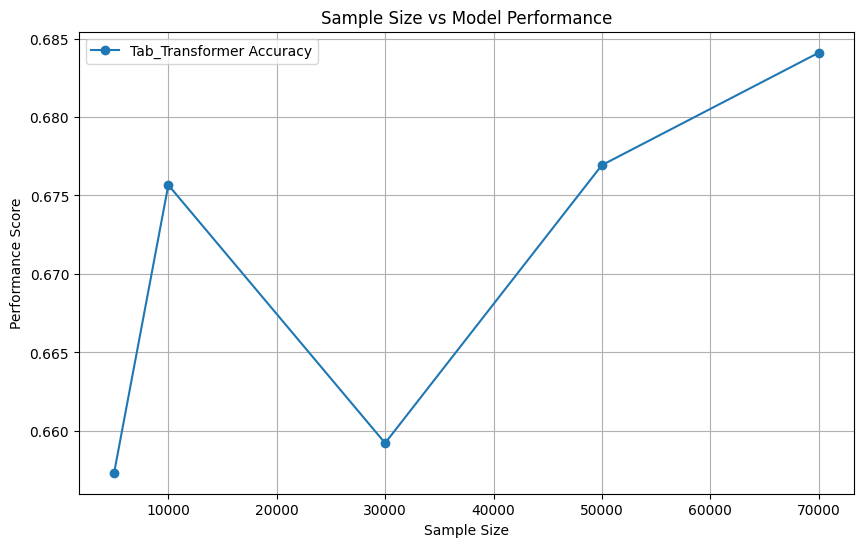

In [21]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, Tab_Transformer_results, marker="o", linestyle="-", label="Tab_Transformer Accuracy")


#plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

# 시각화

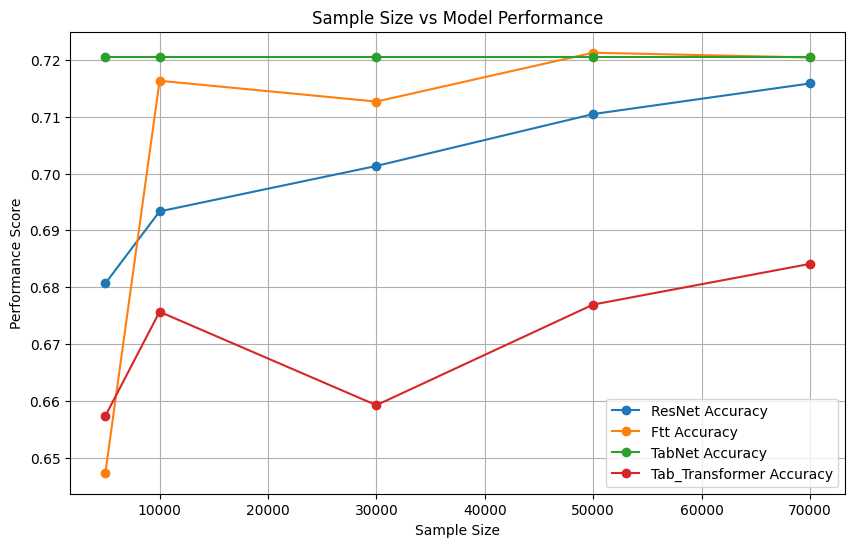

In [22]:
# 종합 시각화 결과 . 
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, resnet_results, marker="o", linestyle="-", label="ResNet Accuracy")
plt.plot(data_sizes, ftt_results, marker="o", linestyle="-", label="Ftt Accuracy")
plt.plot(data_sizes, tabnet_results, marker="o", linestyle="-", label="TabNet Accuracy")
plt.plot(data_sizes, Tab_Transformer_results, marker="o", linestyle="-", label="Tab_Transformer Accuracy")


plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
resnet_results

[0.6806666666666666,
 0.6933333333333334,
 0.7013333333333334,
 0.7104666666666667,
 0.7158571428571429]

In [24]:
ftt_results

[0.6473333333333333,
 0.7163333333333334,
 0.7126666666666667,
 0.7212666666666666,
 0.7204285714285714]

In [25]:
tabnet_results

[0.7204285714285714,
 0.7204285714285714,
 0.7204285714285714,
 0.7204285714285714,
 0.7204285714285714]

In [26]:
Tab_Transformer_results

[0.6573333333333333,
 0.6756666666666666,
 0.6592222222222223,
 0.6769333333333334,
 0.6840952380952381]